In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('lemmatized.txt') as f:
    reviews = f.read().splitlines()

reviews[0]

"['jan', 'be', 'very', 'friendly', 'and', 'welcome', 'host', 'the', 'apartment', 'be', 'great', 'and', 'the', 'area', 'be', 'sooo', 'amaze', 'lot', 'of', 'nice', 'cafe', 'and', 'shop', 'enjoy', 'my', 'time', 'there', 'lot']"

In [3]:
reviews = [review.replace('\'', '').strip('][').split(', ') for review in reviews]
reviews[0]

['jan',
 'be',
 'very',
 'friendly',
 'and',
 'welcome',
 'host',
 'the',
 'apartment',
 'be',
 'great',
 'and',
 'the',
 'area',
 'be',
 'sooo',
 'amaze',
 'lot',
 'of',
 'nice',
 'cafe',
 'and',
 'shop',
 'enjoy',
 'my',
 'time',
 'there',
 'lot']

## Bigrams generation

In [4]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(reviews, min_count=3, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[reviews]
sentences[1]

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


['it',
 'be',
 'really',
 'nice',
 'area',
 'food',
 'park',
 'transport',
 'be',
 'perfect']

In [5]:
from collections import defaultdict

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

61035

In [6]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['be', 'and', 'the', 'to', 'in', 'very', 'we', 'of', 'great', 'it']

## Word2Vec model

In [7]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=20,
                     window=4,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=4)

In [8]:
from time import time

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.23 mins


In [9]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 9.27 mins


In [10]:
# w2v_model.save("word2vec_no_stopwords.model")

## Exploring the model

In [11]:
w2v_model.wv.most_similar(positive=["apartment"])

[('flat', 0.8238459229469299),
 ('appartment', 0.5191665291786194),
 ('studio', 0.4929877817630768),
 ('spacious', 0.4880349338054657),
 ('modern', 0.44914305210113525),
 ('apt', 0.43771812319755554),
 ('bright', 0.43572455644607544),
 ('clean', 0.4341098964214325),
 ('itself', 0.4338478744029999),
 ('stylish', 0.4044039249420166)]

## Clustering model

In [12]:
from sklearn.cluster import KMeans
import numpy as np

kmeans_model = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeans_model.fit(X=w2v_model.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [13]:
w2v_model.wv.similar_by_vector(kmeans_model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('metal', 0.5876560807228088),
 ('the', 0.5459574460983276),
 ('small', 0.53319251537323),
 ('stone', 0.5325789451599121),
 ('mount', 0.5291525721549988),
 ('plastic', 0.5266245007514954),
 ('which', 0.521183431148529),
 ('rug', 0.5093643665313721),
 ('leather', 0.5082668662071228),
 ('no', 0.5009970664978027)]

In [14]:
negative_cluster_index = 1
negative_cluster_center = kmeans_model.cluster_centers_[negative_cluster_index]
positive_cluster_center = kmeans_model.cluster_centers_[1-negative_cluster_index]

In [15]:
# dfWords = pd.DataFrame(w2v_model.wv.vocab.keys())

dfWords = pd.DataFrame(w2v_model.wv.key_to_index.keys())
dfWords.columns = ['words']
dfWords['vectors'] = dfWords.words.apply(lambda x: w2v_model.wv[f'{x}'])
dfWords['cluster'] = dfWords.vectors.apply(lambda x: kmeans_model.predict([np.array(x)]))
dfWords.cluster = dfWords.cluster.apply(lambda x: x[0])
dfWords.head()

words                                            vectors  cluster
0    be  [0.18196468, 0.22994295, -0.026644967, 0.14577...        1
1   and  [-0.33863708, 0.36706352, -0.08271597, 0.04687...        0
2   the  [0.50414634, 0.13799481, 0.23293671, -0.135687...        1
3    to  [0.22348528, 0.23045121, -0.292481, -0.0895818...        1
4    in  [0.24728559, 0.6819449, 0.65819436, -0.5162844...        1

In [16]:
dfWords['cluster_value'] = [-1 if i==negative_cluster_index else 1 for i in dfWords.cluster]
dfWords['closeness_score'] = dfWords.apply(lambda x: 1/(kmeans_model.transform([x.vectors]).min()), axis=1)
dfWords['sentiment_coeff'] = dfWords.closeness_score * dfWords.cluster_value
dfWords[dfWords['cluster_value'] == -1].head()

words                                            vectors  cluster  \
0    be  [0.18196468, 0.22994295, -0.026644967, 0.14577...        1   
2   the  [0.50414634, 0.13799481, 0.23293671, -0.135687...        1   
3    to  [0.22348528, 0.23045121, -0.292481, -0.0895818...        1   
4    in  [0.24728559, 0.6819449, 0.65819436, -0.5162844...        1   
7    of  [0.07368552, 0.8856529, 0.44896266, -0.3570296...        1   

   cluster_value  closeness_score  sentiment_coeff  
0             -1         0.193416        -0.193416  
2             -1         0.161017        -0.161017  
3             -1         0.114374        -0.114374  
4             -1         0.142567        -0.142567  
7             -1         0.099302        -0.099302

In [33]:
dfCleanedReviews = pd.DataFrame([' '.join(review) for review in reviews], columns=['comments'])
dfCleanedReviews.head()

comments
0  jan be very friendly and welcome host the apar...
1  it be really nice area food park transport be ...
2  we have very nice stay in berlin thanks to jan...
3  great location close to mauerpark kastanienall...
4  apartment very well locate close to everything...

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm=None)
transformed = tfidf.fit_transform(dfCleanedReviews['comments'].tolist())
features = pd.Series(tfidf.get_feature_names())

In [58]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    # print('Name:', x.name)
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)
    # print(dictionary.keys())
    # print('Dictionary[there]', dictionary['there'])
    # print('Dictionary[be]', dictionary['be'])
    # print(dictionary.keys())
    # print(x.comments)
    try:
        res = list(map(lambda y:dictionary[f'{y}'], x.comments.split()))
    except KeyError:
        res = [0 for i in x.comments.split()]
    # print('Res[0]:', res[0])
    # return list(map(lambda y:dictionary[f'{y}'], x.comments.split()))
    return res

In [59]:
replaced_tfidf_scores = dfCleanedReviews.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)
type(replaced_tfidf_scores)

Name: 0
Name: 1
Name: 2
Name: 3
Name: 4
Name: 5
Name: 6
Name: 7
Name: 8
Name: 9
Name: 10
Name: 11
Name: 12
Name: 13
Name: 14
Name: 15
Name: 16
Name: 17
Name: 18
Name: 19
Name: 20
Name: 21
Name: 22
Name: 23
Name: 24
Name: 25
Name: 26
Name: 27
Name: 28
Name: 29
Name: 30
Name: 31
Name: 32
Name: 33
Name: 34
Name: 35
Name: 36
Name: 37
Name: 38
Name: 39
Name: 40
Name: 41
Name: 42
Name: 43
Name: 44
Name: 45
Name: 46
Name: 47
Name: 48
Name: 49
Name: 50
Name: 51
Name: 52
Name: 53
Name: 54
Name: 55
Name: 56
Name: 57
Name: 58
Name: 59
Name: 60
Name: 61
Name: 62
Name: 63
Name: 64
Name: 65
Name: 66
Name: 67
Name: 68
Name: 69
Name: 70
Name: 71
Name: 72
Name: 73
Name: 74
Name: 75
Name: 76
Name: 77
Name: 78
Name: 79
Name: 80
Name: 81
Name: 82
Name: 83
Name: 84
Name: 85
Name: 86
Name: 87
Name: 88
Name: 89
Name: 90
Name: 91
Name: 92
Name: 93
Name: 94
Name: 95
Name: 96
Name: 97
Name: 98
Name: 99
Name: 100
Name: 101
Name: 102
Name: 103
Name: 104
Name: 105
Name: 106
Name: 107
Name: 108
Name: 109
Name: 110


pandas.core.series.Series

In [60]:
sentiment_dict = dict(zip(dfWords.words.values, dfWords.sentiment_coeff.values))

In [61]:

def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [63]:
replaced_closeness_scores = dfCleanedReviews['comments'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [67]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, dfCleanedReviews['comments']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = 'Positive' if replacement_df.sentiment_rate>0 else 'Negative'
# replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]
replacement_df.head()

sentiment_coeff  \
0  [0.08298480877927689, -0.19341618731421975, 0....   
1  [-0.14721533917634494, -0.19341618731421975, 0...   
2  [0.11380159607947953, -0.1330708384148905, 0.1...   
3  [0.1395283646087198, -0.12010490960416625, -0....   
4  [-0.1368101052070951, 0.13707177502473997, -0....   

                                        tfidf_scores  \
0  [6.45518200427728, 3.6108140688773807, 1.62336...   
1  [2.034512963851828, 2.407209379251587, 2.64191...   
2  [2.091150860411193, 4.119858950780223, 4.87009...   
3  [1.8501655371557688, 2.159718877149754, 2.7123...   
4  [3.927308953862587, 3.246732537406179, 2.84084...   

                                            sentence  sentiment_rate  \
0  jan be very friendly and welcome host the apar...        0.426262   
1  it be really nice area food park transport be ...       -1.336937   
2  we have very nice stay in berlin thanks to jan...       -5.910717   
3  great location close to mauerpark kastanienall...       -2.469521   
4  apartment very well locate close to everything...       -8.946567   

   prediction  
0           1  
1           0  
2           0  
3           0  
4           0

In [68]:
replacement_df.to_csv('sentiment_dataset_2_clusters.csv', sep=',', index=False, header=True)

inertia_ 1198859.212080944
inertia_ 1153476.3842296554
inertia_ 1117214.0643024195
inertia_ 1097866.2147126081
inertia_ 1083872.5825630971
inertia_ 1070915.6694993107
inertia_ 1059808.775974189
inertia_ 1050916.7867042492
inertia_ 1043518.0564049281
inertia_ 1037591.1255252063


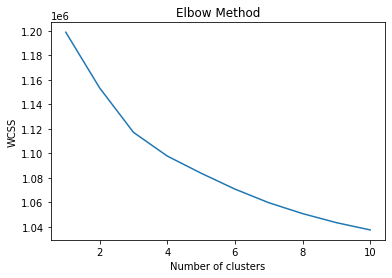

In [17]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X=w2v_model.wv.vectors.astype('double'))
    # inertia_ is sum of squared distance of samples to its closest cluster centers.
    wcss.append(kmeans.inertia_)
    print("inertia_", kmeans.inertia_)
    # print("wcss", within_css(kmeans))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
from sklearn.metrics import silhouette_score

def kmeansSilhouette(X,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(X)
        labels = km.predict(X)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :", silhouette_score(X, labels, metric='euclidean'))

In [19]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeansSilhouette(w2v_model.wv.vectors.astype('double'), rangeClusters)

For n_clusters = 2 The computed average silhouette_score is : 0.03568915449322706
For n_clusters = 3 The computed average silhouette_score is : 0.04650108080512448
For n_clusters = 4 The computed average silhouette_score is : 0.04104709372939465
For n_clusters = 5 The computed average silhouette_score is : 9.204038798711663e-05
For n_clusters = 6 The computed average silhouette_score is : -0.009964131583840713
For n_clusters = 7 The computed average silhouette_score is : -0.014528427951796166
For n_clusters = 8 The computed average silhouette_score is : -0.014357149385742974
For n_clusters = 9 The computed average silhouette_score is : -0.06076472493353667
For n_clusters = 10 The computed average silhouette_score is : -0.05848595183850541


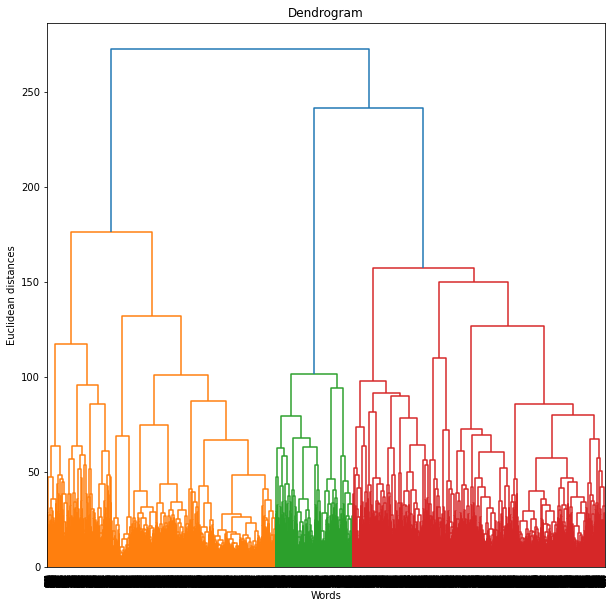

In [20]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(w2v_model.wv.vectors.astype('double'), method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Words')
plt.ylabel('Euclidean distances')
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
y_hc = hc.fit_predict(w2v_model.wv.vectors.astype('double'))

In [22]:
dfWords2 = pd.DataFrame(data=[w2v_model.wv.key_to_index.keys(), y_hc]).T
dfWords2.columns = ['words', 'clusters']
dfWords2['vectors'] = dfWords2.words.apply(lambda x: w2v_model.wv[f'{x}'])
dfWords2.head()

words clusters                                            vectors
0    be        1  [0.18196468, 0.22994295, -0.026644967, 0.14577...
1   and        1  [-0.33863708, 0.36706352, -0.08271597, 0.04687...
2   the        0  [0.50414634, 0.13799481, 0.23293671, -0.135687...
3    to        2  [0.22348528, 0.23045121, -0.292481, -0.0895818...
4    in        0  [0.24728559, 0.6819449, 0.65819436, -0.5162844...

In [23]:
batch_nrs = len(w2v_model.wv.key_to_index.keys()) // 500
batch_nrs

17

In [24]:
silhouette_scores = []

for i in range(batch_nrs):
    silhouetteScore = silhouette_score(w2v_model.wv.vectors[i*500:(i+1)*500],
                                       y_hc[i*500:(i+1)*500],
                                       metric='euclidean')
    print(silhouetteScore)
    silhouette_scores.append(silhouetteScore)

finalSilhouetteScore = np.mean(silhouette_scores)
finalSilhouetteScore


0.017921766
-0.0039490135
0.0073534683
0.012075182
0.023835551
0.017656673
0.021196665
0.02434948
0.018411731
0.027991818
0.014742795
0.015937412
0.015789093
0.02498246
0.015228073
0.013971454
0.01666799


0.016715448